In [1]:
# Import all the requiered dependencies
import numpy as np
import os
import sys
from tqdm import tqdm

# Graphic tools
import matplotlib.pyplot as plt

# Animation tools
from IPython.display import HTML
from matplotlib.animation import PillowWriter

# Tools from Swarm Systems Lab simulator
from ssl_simulator import createDir
from ssl_simulator.math import uniform_distrib, R_2D_matrix, gen_Z_random
from ssl_simulator.visualization import set_paper_parameters

set_paper_parameters(fontsize=12)

# --------------------------------------------------------------------------------------

# Python project to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import the main module of the project
import dfc as dfc

# Output directory
OUTPUT_PATH = os.path.join("..", "output")
createDir(OUTPUT_PATH)

The directory '../output' already exists!


## Centralized simulation

In [ ]:
# Generate the robots distribution and set the initial positions
N = 70
lims = [1, 2]
rc0 = [0, 0]

p0 = uniform_distrib(N=N, lims=lims, rc0=rc0, seed=2024)

# Generating the simulator class
dt = 0.01
lambda_d = [10, 5]
ke = 0.2

sim = dfc.Simulator(p0=p0, dt=dt, lambda_d=lambda_d, ke=ke)

# ----------------------------------------------------------------------
# Execute the simulation given a desired final time stamp
# ----------------------------------------------------------------------
tf = 2.5

t_list = np.arange(0, tf, dt)
for it in tqdm(range(len(t_list))):
    sim.int_euler()

In [ ]:
dfc.plot_centralized(sim, lim=11, dpi=100, figsize=(12,7))

In [ ]:
animator = dfc.AnimBasic(sim, lim=11, agent_r=0.1, tail_alpha=0.7)

# -- MP4 
anim = animator.gen_animation()
HTML(anim.to_html5_video()) # It takes a loooot of time...

# -- GIF
# writer = PillowWriter(fps=15, bitrate=1800)
# anim.save(os.path.join(OUTPUT_FOLDER, "test.gif"),
#         writer = writer)

## Distributed simulation

In [2]:
# Generate the robots distribution and set the initial positions
N = 70
lims = [2, 2]
rc0 = [0, 1]

p0 = uniform_distrib(N=N, lims=lims, rc0=rc0, seed=2024)

# Generate the graph
Z = gen_Z_random(N, rounds=3, seed=2024)

# Generating the simulator class
dt = 0.01
lambda_d = [10, 4]
ke = 0.2

sim = dfc.SimulatorDistr(p0=p0, Z=Z, dt=dt, lambda_d=lambda_d, 
                     ke=ke, kpc=1, its_pc=8, kc=1, its_c=8)

# Graph connectivity (lambda2)
print(r"$\lambda_2$:", sim.lambda_min)

$\lambda_2$: 1.3895962834572255


In [3]:
# ----------------------------------------------------------------------
# Execute the simulation given a desired final time stamp
# ----------------------------------------------------------------------
tf = 2.5

t_list = np.arange(0, tf, dt)
for it in tqdm(range(len(t_list))):
    sim.int_euler()

100%|██████████| 250/250 [00:08<00:00, 29.08it/s]


In [ ]:
dfc.plot_distributed(sim, lim=11, dpi=100, figsize=(10,5))
# plot_distributed_small(sim, lim=11, dpi=400, figsize=(10,5))

In [ ]:
animator = dfc.AnimBasic(sim, lim=7.5, agent_r=0.1, tail_alpha=0.7)

# -- MP4 
anim = animator.gen_animation()
HTML(anim.to_html5_video()) # It takes a loooot of time...

# -- GIF
# writer = PillowWriter(fps=15, bitrate=1800)
# anim.save(os.path.join(OUTPUT_FOLDER, "test.gif"),
#         writer = writer)

## Resilience simulation: robots orbit around the centroid

In [14]:
p0 = uniform_distrib(N=N, lims=lims, rc0=rc0)
print(p0[-4:])
print(p0[-1])

[[ 0.55389802 -1.25809727]
 [ 0.10059853 -0.17176106]
 [-0.22250523  0.00925944]
 [ 1.3155709  -0.70959977]]
[ 1.3155709  -0.70959977]


In [15]:
# Generate the robots distribution and set the initial positions
N = 70
lims = [2, 2]
rc0 = [0, 0]

p0 = uniform_distrib(N=N, lims=lims, rc0=rc0)

# Generating the simulator class
dt = 0.01
lambda_d = [10, 5]
ke = 0.2

sim = dfc.Simulator(p0=p0, dt=dt, lambda_d=lambda_d, ke=ke)

# ----------------------------------------------------------------------
# Execute the simulation given a desired final time stamp
# ----------------------------------------------------------------------
tf = 10

R1 = R_2D_matrix(np.pi/3*dt)
R2 = R_2D_matrix(np.pi/2*dt)
R3 = R_2D_matrix(np.pi/4*dt)
R4 = R_2D_matrix(np.pi*dt)
sim.active[N-4:N] = 0

t_list = np.arange(0, tf, dt)
for it in tqdm(range(len(t_list))):
    sim.variables["p"][-1] = (R1 @ sim.variables["p"][-1][:,None]).squeeze()
    sim.variables["p"][-2] = (R2 @ sim.variables["p"][-2][:,None]).squeeze()
    sim.variables["p"][-3] = (R3 @ sim.variables["p"][-3][:,None]).squeeze()
    sim.variables["p"][-4] = (R4 @ sim.variables["p"][-4][:,None]).squeeze()
    sim.int_euler()

100%|██████████| 1000/1000 [00:00<00:00, 5587.75it/s]


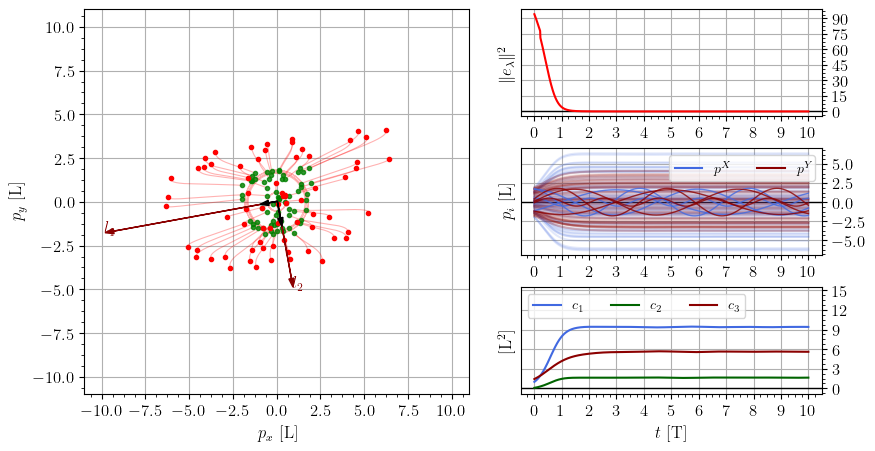

In [16]:
dfc.plot_resilience_osc(sim, lim=11, dpi=100, figsize=(10,5), t_sep=1)
# plot_resilience_small(sim, lim=11, dpi=400, figsize=(10,5), t_sep=1)

In [ ]:
animator = dfc.AnimBasic(sim, lim=7.5, agent_r=0.1, tail_alpha=0.7)

# -- MP4 
anim = animator.gen_animation()
HTML(anim.to_html5_video()) # It takes a loooot of time...

# -- GIF
# writer = PillowWriter(fps=15, bitrate=1800)
# anim.save(os.path.join(OUTPUT_FOLDER, "test.gif"),
#         writer = writer)

## Resilience simulation: robots disconnect during the mission

In [2]:
# Generate the robots distribution and set the initial positions
N = 70
lims = [3, 1]
rc0 = [0, 0]

p0 = uniform_distrib(N=N, lims=lims, rc0=rc0, seed=2024)

# Generate the graph
Z = gen_Z_random(N, rounds=3, seed=2024)

# Generating the simulator class
dt = 0.001
lambda_d = [10, 4]

epsilon_phat = 1/4
epsilon_chat = 1/10

sim = dfc.SimulatorDistrNew(
    p0=p0, Z=Z, dt=dt, lambda_d=lambda_d, ke=0.8, kpc=1, kc=1, 
    epsilon_phat=epsilon_phat, epsilon_chat=epsilon_chat)

# Graph connectivity (lambda2)
print(Z)
print(r"$\lambda_0$:", sim.lambda_min)

[(0, 24), (24, 27), (27, 55), (27, 34), (24, 49), (55, 30), (49, 39), (24, 38), (34, 54), (39, 52), (55, 56), (27, 10), (55, 15), (30, 32), (0, 64), (55, 51), (24, 37), (64, 63), (27, 67), (39, 29), (38, 26), (29, 23), (39, 40), (34, 57), (27, 41), (29, 16), (10, 18), (57, 2), (64, 22), (63, 59), (27, 66), (57, 9), (49, 21), (32, 58), (51, 12), (26, 46), (58, 14), (30, 50), (39, 19), (52, 65), (21, 47), (18, 20), (23, 44), (67, 4), (14, 8), (0, 7), (41, 69), (22, 35), (21, 5), (18, 33), (21, 53), (52, 31), (39, 68), (35, 60), (18, 61), (7, 13), (24, 17), (12, 45), (52, 25), (39, 3), (35, 28), (65, 36), (56, 42), (25, 48), (31, 11), (48, 1), (50, 62), (10, 6), (29, 43), (0, 27), (0, 66), (0, 32), (27, 22), (32, 12), (32, 15), (0, 44), (32, 41), (66, 40), (41, 1), (32, 21), (0, 14), (0, 8), (14, 69), (40, 50), (40, 55), (15, 43), (39, 25), (43, 58), (43, 64), (21, 36), (55, 45), (40, 59), (64, 11), (15, 17), (22, 42), (15, 19), (45, 2), (15, 37), (0, 28), (67, 53), (2, 26), (55, 63), (67

In [3]:
# ----------------------------------------------------------------------
# Execute the simulation given a desired final time stamp
# ----------------------------------------------------------------------
tf = 2

t_list = np.arange(0, tf, dt)
for it in tqdm(range(len(t_list))):

    # [!!] Killing robots may disconect the graph, yielding to numerical errors
    # in the simulation (it has to be fixed)

    if it > 0.3/dt:
        sim.kill_agent(np.arange(0,5,1))
    if it > 0.5/dt:
        sim.kill_agent(np.arange(5,10,1))
    if it > 1/dt:
        sim.kill_agent(np.arange(10,15,1))

    sim.int_euler()

100%|██████████| 2000/2000 [00:10<00:00, 183.10it/s]


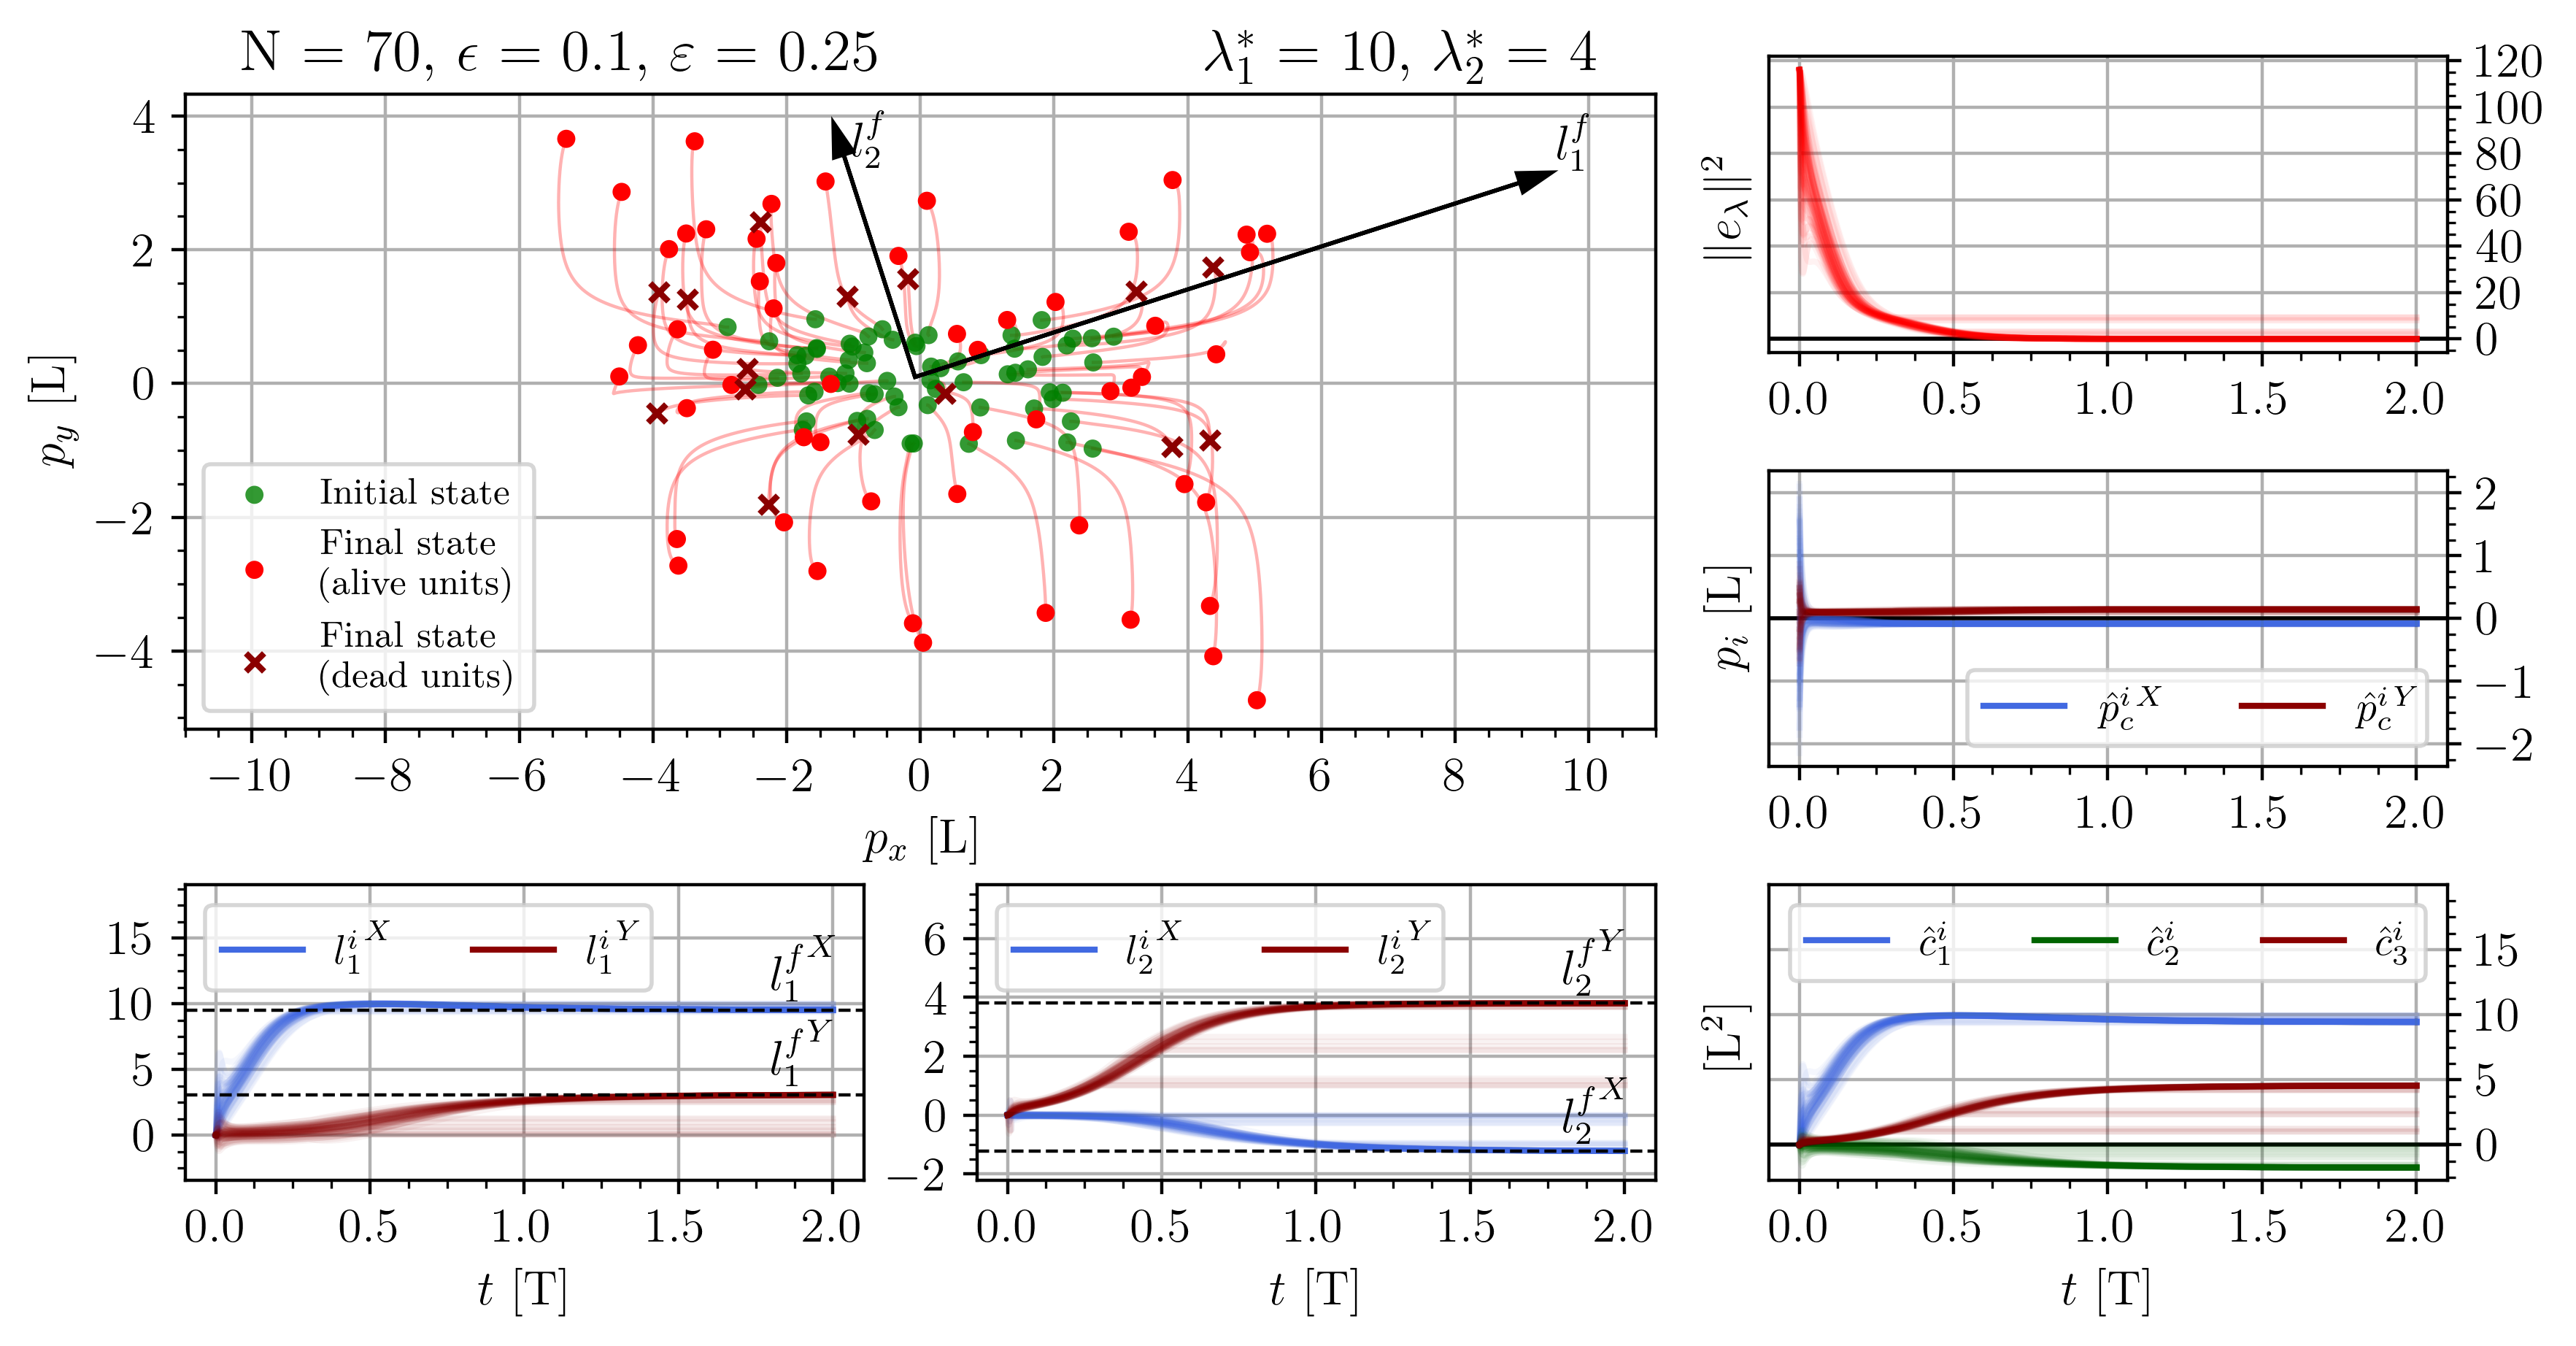

In [4]:
# Generate the plot
dfc.plot_resilience_paper(
    sim, limx=11, dpi=400, figsize=(10,5), t_sep=0.5,
    title=rf"N = {N}, $\epsilon$ = {epsilon_chat}, $\varepsilon$ = {epsilon_phat} " +
    rf"$\qquad\qquad\quad$ $\lambda_1^*$ = {lambda_d[0]}, $\lambda_2^*$ = {lambda_d[1]}")